### The input is a file with format: timestamp, personId, x, y
#### Change randomized so that the id's change also

#### make correlated groups of people

 


In [591]:
import numpy as np
init_timestamp = 1436047260000 
beta = (60/55)*60*1000 # in ms, according to the paper Freudiger 2015, mean time delay between packets
sigma_est = 3 # the average gaussian error of the optimization by multilateration
half_dist_teleport =10 # half of the distance between two twin points
sigma_teleport = 3 # the average displacement of the twin from the firsty generated position
measurement_delay = 1000 # in ms , delay between two measurements in the original positions
randomized_probability = 0.15 # the probability that a mac address is randomized
path_original_positions = "F:/Arena_sim_data/original_positions_size_" # here are written the original positions (ground truth)
path_fake_positions = "F:/Arena_sim_data/fake_positions_size_" # here come the simulated positions after introducing uncertainties
filepath_method_output = "F:/Arena_sim_data/output/size_" # after applying the method, here resides the output of it

In [546]:
# for all persons generates (simulates) the first moment they were detected
def generate_first_moment_visible(crowd_size): #initialization      
    next_moment =[]
    for i in range(0, crowd_size):
        delay = np.random.exponential(beta)
        next_moment.append(int(init_timestamp  + delay))    
    return next_moment    

In [547]:
#test
next_moment = generate_first_moment_visible(3)
next_moment

[1436047263370, 1436047346174, 1436047292513]

In [548]:
# given a timestamp, generates the next moment for a particular device to be detected
def gen_next_moment(timestamp_now): # next moment is drawn from exponential(1/beta) distribution
    delay = np.random.exponential(beta)+1# avoid 0
    return int(timestamp_now + delay)

In [549]:
#test
next_mom = gen_next_moment(3)

In [551]:
# makes a new record in the format of the json file that is output of Arena multilateration and input to the density estimation method
def make_new_record(record, new_position, randomized):#record = [timestamp, personId, x, y], new_position = [x,y]
    sigma_x =  np.random.exponential(sigma_est)
    sigma_y =  np.random.exponential(sigma_est)
    new_record = {}
    new_record["measurementTimestamp"] = record[0]
    new_record["value"] = {}
    new_record["value"]["sourceMac"] = record[1]
    new_record["value"]["averagecoordinate"] = {}
    new_record["value"]["averagecoordinate"]["avg"] = {}
    new_record["value"]["averagecoordinate"]["avg"]["coordinates"] =[new_position[0], new_position[1], 0.0]
    new_record["value"]["averagecoordinate"]["error"] = {}
    new_record["value"]["averagecoordinate"]["error"]["coordinates"] = [sigma_x, sigma_y, 1000.0]#in the real data for z is 1000
    new_record["value"]["trackeeHistory"]={}
    new_record["value"]["trackeeHistory"]["localMac"] = randomized
    return new_record

In [552]:
#test
b = make_new_record([0,1,3,4], [5,6], 0)

In [553]:
b

{'measurementTimestamp': 0,
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [7.314660598037799, 0.6451090998737659, 1000.0]}},
  'sourceMac': 1,
  'trackeeHistory': {'localMac': 0}}}

In [554]:
# returns a list denoting for every mac adress if it has been randomized or not
def generate_randomized(crowd_size):
    randomized = [0 for i in range(0, crowd_size)]
    for i in range(0, crowd_size):
        r = np.random.rand()
        if r < randomized_probability:
            randomized[i] = 1
    return randomized

In [555]:
#test
randomized = generate_randomized(10)

In [556]:
randomized


[1, 1, 0, 0, 0, 0, 1, 0, 0, 1]

In [557]:
# given a position x, generates a new coordinate x' according to the twins distribution
def draw_new_coordinate(position, modes_half_distance=10.0, sigma=5.0):
    rand_mode = np.random.rand()
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    mu = position + rand_mode*modes_half_distance
    new_pos = np.random.normal(mu, sigma)
    return new_pos
    

In [558]:
# given a location (x, y) in record = [timestamp, address, x,  y], draws a new location (x',y') according to the twins distribution
def create_teleportation_effect_single(record, modes_half_distance, sigma):            
        record_x = draw_new_coordinate(record[2], modes_half_distance, sigma)
        record_y = draw_new_coordinate(record[3], modes_half_distance, sigma)
        return [record_x, record_y]

In [559]:
# given a list of positions and the size of the crowd, simulates new data that includes the uncertainties
def make_fake_data(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    next_moment = generate_first_moment_visible(crowd_size)
    randomized = generate_randomized(crowd_size)
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]
        if next_moment[person] > timestamp-measurement_delay and next_moment[person] <= timestamp:#timestamp
                new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
                fake_record = make_new_record(record, new_position, randomized[person])
                fake_positions.append(fake_record)                
                next_moment[person] = gen_next_moment(next_moment[person])
    return fake_positions            

In [560]:
# given density of the crowd, returns the maximal velocity that a person can have by Weidmann's equation
def get_max_velocity(crowd_density):#by Weidmann's equation
    rho = crowd_density+0.00001 #avoid division by 0
    v_0=1.34 #speed at 0 density
    gamma = 1.913 #fit parameter
    rho_max = 5.4 #at this density movement is not possible
    v =v_0*(1-np.exp(-gamma*(1/rho-1/rho_max)))
    v = max(0, v)
    return v

In [561]:
# a function that generates a random number in {-1,1}
def gen_rand_mode():
    rand_mode = np.random.rand() 
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    return rand_mode

In [562]:
# creates the original (ground truth) positions of the crowd assuming random motion (close to Brownian, 4 directions). The velocity depends on the crowd density
from scipy.stats import norm
def create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []    
    i = 0
    dt = measurement_delay/1000#from ms to s
    density = crowd_size/(width_stadium*length_stadium)#should be the local ideally
    velocity = get_max_velocity(density)
    delta =velocity*dt  #for the brownian motion, how many meters per dt:    
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(0, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            #new_x = old_x + norm.rvs(scale=delta**2*dt) # this is very slow as it uses inverse functions
            #new_y = old_y + norm.rvs(scale=delta**2*dt)
            rand_mode = gen_rand_mode()
            new_x = old_x + delta*rand_mode    
            rand_mode = gen_rand_mode()            
            new_y = old_y + delta*rand_mode
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                positions.append([init_timestamp+ timestamp, person, new_x, new_y])    
            else:
                positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [563]:
import json

def write_fake_positions(positions,filename):
    file = open(filename, 'w')
    file.close()
    with open(filename, 'a') as outfile:
        for record in positions:
            json.dump(record, outfile)  
            outfile.write("\n")
        

In [564]:
import pickle

def write_original_positions(positions, filepath):   
    with open(filepath, 'wb') as fp:
        pickle.dump(positions, fp)

In [565]:

def read_original_positions( filepath):   
    with open(filepath, 'rb') as fp:
        positions = pickle.load(fp)
    return positions    

In [566]:
def makedata(crowd_size, step, howmany):
    #crowd_size = 65000
    #step = 5000
    for i in range(0, howmany):
        crowd_size = crowd_size + step     
        print(crowd_size)
        positions = create_positions(init_timestamp, crowd_size, 300*1000 , 105, 68)#300 sec
        write_original_positions(positions, path_original_positions + str(crowd_size)+".pkl")
        fake_positions = make_fake_data(crowd_size, positions)
        write_fake_positions(fake_positions, path_fake_positions + str(crowd_size)+".json")        

In [23]:
#makedata(0, 5000, 15)

In [567]:
# this one is not used anymore I think
def create_teleportation_effect(positions, modes_distance, sigma):
    for record in positions:
        record[2] = draw_new_coordinate(record[2], modes_distance, sigma)
        record[3] = draw_new_coordinate(record[3], modes_distance, sigma)
    return positions    

In [583]:
# gets a snapshot of the crowd detected at time [timestamp, timestamp + interval),  interval is in seconds
def get_a_snapshot(positions,  timestamp, interval):    
    if interval==0:
        snapshot = []        
        for position in positions:
            if position[0] == timestamp:
                snapshot.append(position)            
    else:
        #print("Timestamp: " + str(timestamp))
        snapshot = []        
        counted = {}
        for position in positions:
            if position[0] >= timestamp and position[0] < timestamp + interval*1000:
                if position[1] not in counted:
                    #print("appending " + str(position[1]))
                    snapshot.append(position)
                    counted[position[1]] = True
    return snapshot        

In [32]:
#get_a_snapshot(positions, 0)

In [569]:
# returns the number of people in the given box
def get_crowd_count_in_square(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_center - half_width_x and record[2] < x_center + half_width_x:
            if record[3] > y_center - half_length_y and record[3] < y_center + half_length_y:
                crowd_count +=1
    return crowd_count

In [570]:
import pickle
def read_original_positions(filepath):
    return pickle.load(open( filepath, "rb" ))

In [571]:
def read_fake_positions(filepath):
    data = []
    with open(filepath) as f:
        data = f.readlines()
    fake_positions = []
    for line in data:
        jsline = json.loads(line)
        fake_positions.append([jsline["measurementTimestamp"], jsline["value"]["sourceMac"], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][0], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][1]])
    return fake_positions

In [593]:
#returns the number of people in cell (cell_x, cell_y) as estimated by the method
def get_method_crowd_count(filepath_method_output, crowd_size, cell_x, cell_y, timeperiod):
    filepath = filepath_method_output + str(crowd_size) + "_" 
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    return z_data[cell_y][cell_x]
    

In [573]:
b = get_method_crowd_count(10000, 6, 6, 8)

In [574]:
b

24.678116890926326

In [589]:
# this computes the counts of people from the ground truth, the simulated data and from the method applied to the simulated data
# previously the density estimation should be run on the simulated json data
def run( width_stadium, length_stadium, square_half_size, window, stride, crowd_size, step, iterations):
    errors = []
    differences = []
    scatter = []
    scatter_method = []
    #crowd_size = 0
    #step = 5000
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    for i in range (0, iterations):
        crowd_size +=step
        print(i)
        positions = read_original_positions(path_original_positions + str(crowd_size)+".pkl")
        print(crowd_size)        
        center_x = 32.5 - width_stadium/2.0 # hardcoded , should be pulled outside the function ideally
        center_y = 32.5 - length_stadium/2.0 # also
        original_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, positions, crowd_size, center_x, center_y, square_half_size, square_half_size, 0) 
        original_proportion = original_crowd_count/crowd_size
        positions = []
        fake_positions = read_fake_positions(path_fake_positions + str(crowd_size) + ".json")
        #print(fake_positions[0])
        fake_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, fake_positions, crowd_size, center_x, center_y, square_half_size, square_half_size, 60)
        new_proportion = fake_crowd_count/crowd_size
        diff= new_proportion-original_proportion
        differences.append(diff)
        error= fake_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count+0.0001)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
        fake_positions = []
        method_crowd_count = 1.176*get_method_crowd_count(filepath_method_output,crowd_size, 6, 6, window)# multipied by 1.176 to account of  the randomized adresses
        method_error = method_crowd_count - original_crowd_count
        method_relative_error = method_error/(original_crowd_count+0.0001)
        scatter_method.append([original_crowd_count, method_relative_error ])    
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [errors, differences, scatter, scatter_method,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [ ]:
#makedata(0, 200, 20 )

In [586]:
lists_small = run( 105.0, 68.0, 2.5, 8, 30, 0, 200, 20)

0
200
Original crowd count:1
Fake crowd count:0
Method crowd count:0.743305268785
1
400
Original crowd count:0
Fake crowd count:1
Method crowd count:0.899367441532
2
600
Original crowd count:6
Fake crowd count:1
Method crowd count:1.83363947419
3
800
Original crowd count:3
Fake crowd count:2
Method crowd count:3.45200223615
4
1000
Original crowd count:4
Fake crowd count:4
Method crowd count:2.07345351735
5
1200
Original crowd count:6
Fake crowd count:1
Method crowd count:3.53429196173
6
1400
Original crowd count:1
Fake crowd count:2
Method crowd count:3.59552757381
7
1600
Original crowd count:4
Fake crowd count:1
Method crowd count:5.74675488622
8
1800
Original crowd count:1
Fake crowd count:3
Method crowd count:3.94957065422
9
2000
Original crowd count:4
Fake crowd count:3
Method crowd count:6.14624227778
10
2200
Original crowd count:8
Fake crowd count:1
Method crowd count:8.09511008783
11
2400
Original crowd count:11
Fake crowd count:4
Method crowd count:5.72703515248
12
2600
Origina

In [594]:
lists = run( 105.0, 68.0, 2.5, 8, 30, 0, 5000, 14)

0
5000
Original crowd count:24
Fake crowd count:10
Method crowd count:15.0325764757
1
10000
Original crowd count:39
Fake crowd count:18
Method crowd count:29.0214654637
2
15000
Original crowd count:62
Fake crowd count:26
Method crowd count:54.7194472001
3
20000
Original crowd count:69
Fake crowd count:42
Method crowd count:64.2353782864
4
25000
Original crowd count:97
Fake crowd count:81
Method crowd count:88.97013567
5
30000
Original crowd count:112
Fake crowd count:60
Method crowd count:105.794585186
6
35000
Original crowd count:134
Fake crowd count:73
Method crowd count:128.694360668
7
40000
Original crowd count:140
Fake crowd count:74
Method crowd count:126.682746751
8
45000
Original crowd count:181
Fake crowd count:104
Method crowd count:158.073834163
9
50000
Original crowd count:157
Fake crowd count:97
Method crowd count:175.465905156
10
55000
Original crowd count:159
Fake crowd count:126
Method crowd count:184.436669712
11
60000
Original crowd count:228
Fake crowd count:100
Meth

### Plotting the results of comparison

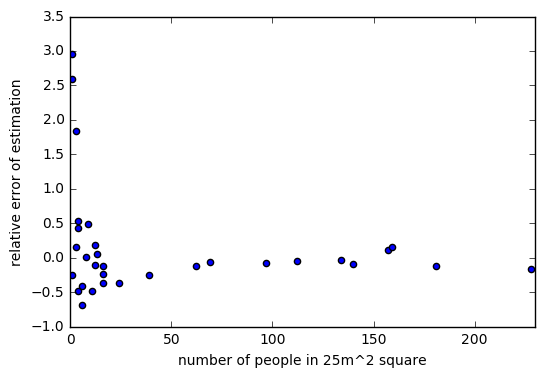

In [596]:

#n = 50
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

x_small = np.array([r[0] for r in lists_small[3] ])
y_small = np.array([r[1] for r in lists_small[3] ])
x = np.array([r[0] for r in lists[3] ])
y = np.array([r[1] for r in lists[3] ])

x= np.concatenate((x_small, x))
y= np.concatenate((y_small, y))

fit = np.polyfit(x, y, deg = 1)

plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('relative error of estimation')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([0, 230])
axes.set_ylim([-1, 3.5])
plt.show()

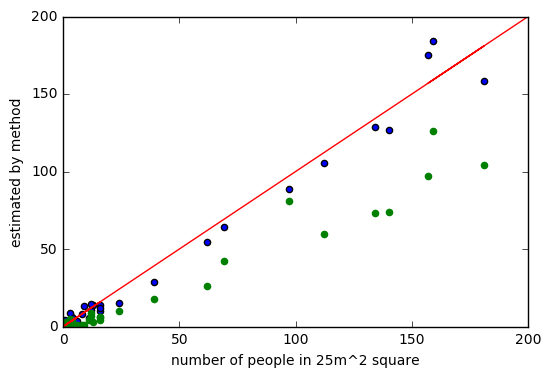

In [597]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
x = np.array([r for r in lists[4] ])
y = np.array([r for r in lists[6] ])

x_small = np.array([r for r in lists_small[4] ])
y_small = np.array([r for r in lists_small[6] ])

x= np.concatenate((x_small, x))
y= np.concatenate((y_small, y))

fit = np.polyfit(x, y, deg = 1)

plt.plot(x,  x , color='red')

plt.scatter(x, y)

x = np.array([r for r in lists[4] ])
y = np.array([r for r in lists[5] ])
x_small = np.array([r for r in lists_small[4] ])
y_small = np.array([r for r in lists_small[5] ])

x= np.concatenate((x_small, x))
y= np.concatenate((y_small, y))

plt.scatter(x, y, color = 'green')

plt.ylabel('estimated by method')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([0, 200])
axes.set_ylim([0,200])
plt.show()

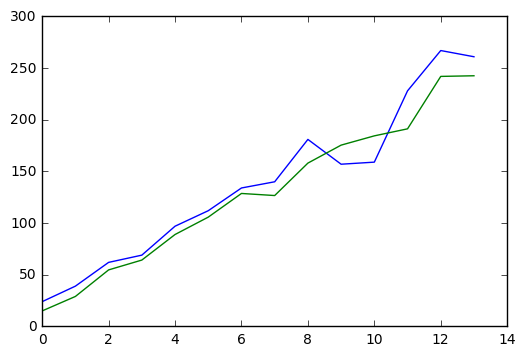

In [598]:
import matplotlib.pyplot as plt
plt.plot(lists[4])
plt.plot(lists[6])

plt.ylabel('')
#plt.xlabel('crowd size (unit:500)')
plt.show()

## Fingerprinting data analysis

In [544]:
def make_fingerprint_data(positions):
    json = {}
    timestamp = 0   
    fing_positions = []
    for record in positions: #record = [timestamp, personId, x, y]          
        fing_record = make_new_record(record, [record[2], record[3]], 0)
        fing_record["value"]["averagecoordinate"]["error"]["coordinates"] = [0.01, 0.01, 1000.0]#bogus errors as placeholders since there are no gaussian errors
        fing_positions.append(fing_record)                               
    return fing_positions            

In [375]:
positions = read_original_positions("F:/ArenaData/Fingerprinting/positions.pkl")
data = make_fingerprint_data(positions) 
write_fake_positions(data,"F:/ArenaData/Fingerprinting/fingerprints_GPS.json")

In [ ]:
positions

In [376]:
positions = read_original_positions("F:/ArenaData/Fingerprinting/positions_fitted.pkl")
data = make_fingerprint_data(positions) 
write_fake_positions(data,"F:/ArenaData/Fingerprinting/fingerprints_fitted.json")

### After the method application

In [218]:
import numpy as np
init_timestamp = 1369908924*1000 + 1804000*1000
measurement_delay = 1000 # in ms
path_original_positions = "F:/ArenaData/Fingerprinting/"
path_fake_positions = "F:/ArenaData/Fingerprinting/"

In [220]:
def get_crowd_count_in_square_fing(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_min and record[2] < x_max:
            if record[3] > y_min and record[3] < y_max:
                crowd_count +=1
    return crowd_count

In [387]:
def get_all_cells(xmin_cell, xmax_cell, ymin_cell, ymax_cell, timeperiod):
    total =0
    filepath = "F:/Arena_sim_data/output/fingerprinted_method"
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    for cell_x in range (int(xmin_cell), int(xmax_cell)):
        for cell_y in range (int(ymin_cell), int(ymax_cell)):
            total += z_data[cell_y][cell_x]
    return total        

In [388]:
def run_fing( width_stadium, length_stadium,  st_window, end_window, stride):
    errors = []
    differences = []
    scatter = []
    scatter_method = []
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    positions = read_original_positions(path_original_positions + "positions.pkl")    
    fake_positions = read_fake_positions(path_fake_positions  + "fingerprints_fitted.json")
    for window in range (st_window, end_window):
        print(window)
        original_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, positions, x_min, x_max, y_min, y_max, belt, 60) 
        if original_crowd_count > 0:
            print("original crowd count = " + str(original_crowd_count))
        fake_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, fake_positions, x_min, x_max, y_min, y_max, belt, 60)
        error= fake_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count+0.0001)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
        method_crowd_count = get_all_cells(xmin_cell, xmax_cell, ymin_cell, ymax_cell, window)
        method_error = method_crowd_count - original_crowd_count
        method_relative_error = method_error/(original_crowd_count+0.0001)
        scatter_method.append([original_crowd_count, method_relative_error ])    
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [errors, differences, scatter, scatter_method,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [433]:
labels = ["", "","","","true", "fitted", "our method"]

In [420]:
x_min = 215
x_max = 310
y_min =  76
y_max = 110
belt = 35
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [ ]:
lists_upper = run_fing( 350, 140, 0, 432,30)

In [512]:
def plotLists(lists, labels):
    plt.plot(lists[0],  '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    plt.plot(lists[1],  ':', color = "red", alpha = 0.8,  label = labels[1])
    plt.plot(lists[2],  alpha = 0.6, color = "blue", label = labels[2])
    plt.legend()
    plt.ylabel('Number of phones detected')
    plt.ylim(0,9)
    plt.xlim(220, 410)
    plt.show()

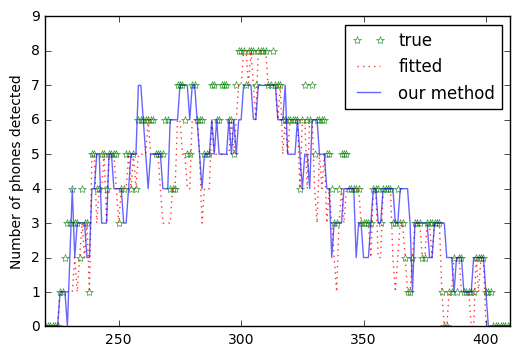

In [513]:
plotLists(lists_upper[4:], labels[4:])

In [403]:
x_min = 215
x_max = 310
y_min =  20
y_max = 50
belt = 35
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [ ]:
lists_down = run_fing(350, 140, 0, 432, 30)

In [492]:
def plotLists2(lists, labels):
    plt.plot(lists[0], '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    plt.plot(lists[1],  ':', color = "red", alpha = 0.8,  label = labels[1])
    plt.plot(lists[2],  alpha = 0.6, color = "blue", label = labels[2])
    plt.legend(loc=2)
    plt.ylabel('Number of phones in the lower box')
    #plt.ylim(0,9)
    plt.xlim(0, 350)
    plt.show()

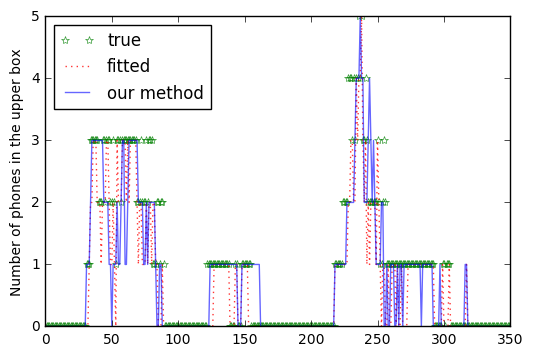

In [493]:
plotLists2(lists_down[4:], labels[4:])

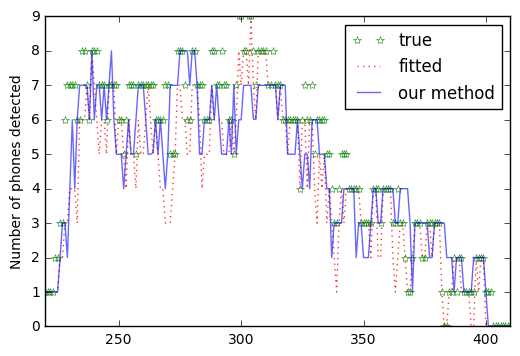

In [529]:
from operator import add
total_lists = []         
for i in range(0,3):
    total_list = list(map (add, lists_down[4:][i] , lists_upper[4:][i]))
    total_lists.append(total_list)
plotLists(total_lists, labels[4:])